In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

In [2]:
def model(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_curr - T1) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [3]:
T1=27.4
T2=0.025
omega1=0.02
phi1=1.53
R1= 250.083 #146.9
R2= 0.565
omega2= 0.018
phi2=1.5

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=36.5
b1=0.1

A=0.3
B=1.31
C=-2.4

b2=0.3
tau_H=10
DD=105
Tmin=14.5
gamma= 1/1095 #1/365
R_L = 300
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

In [4]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

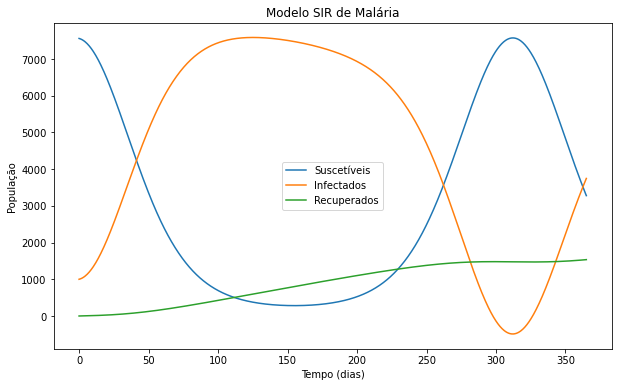

In [5]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [6]:
min(I_H)

-489.73901147308146

In [7]:
max(S_H)

7572.540701016828

In [8]:
S_H[0]

7558.0

In [9]:
gamma

1/1095

In [10]:
n(gamma)

0.000913242009132420

In [11]:
n(1/1000)

0.00100000000000000

In [12]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, 1/1000, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

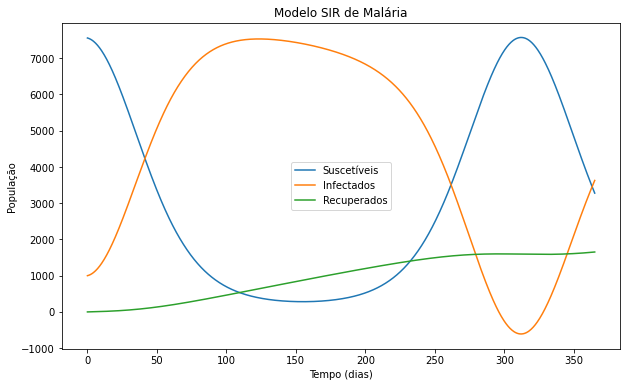

In [13]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [14]:
min(I_H)

-608.5478806833497

Aumentar o $\gamma$ fará cvom que o número mínimo de infectados diminua ainda mais

In [15]:
365*3

1095

In [16]:
365*5

1825

In [17]:
365*4

1460

In [18]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, 1/1825, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

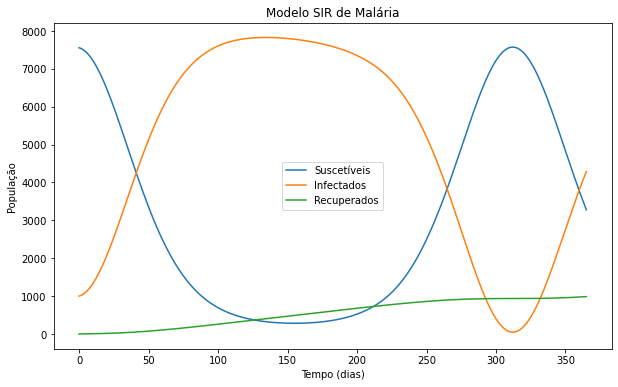

In [19]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

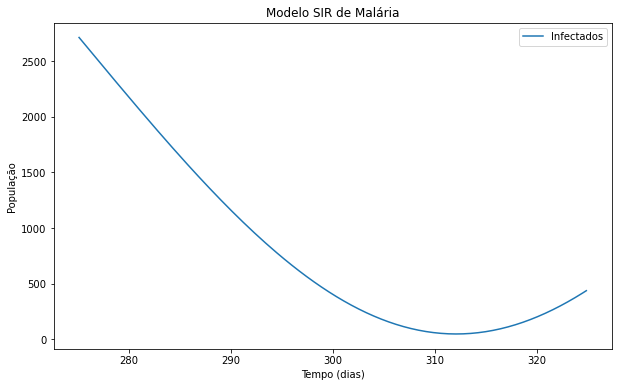

In [20]:
times = sol.t
tempo_inicial = 275
tempo_final = 325

# Encontrando os índices correspondentes ao intervalo desejado
indice_tempo_inicial = np.argmax(times >= tempo_inicial)
indice_tempo_final = np.argmax(times >= tempo_final)

S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
#plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times[indice_tempo_inicial:indice_tempo_final], I_H[indice_tempo_inicial:indice_tempo_final], label='Infectados')
#plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

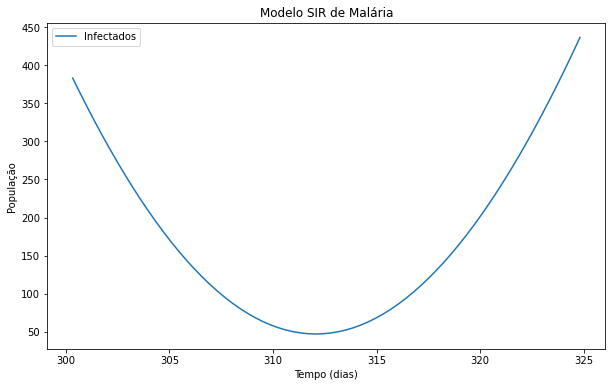

In [21]:
times = sol.t
tempo_inicial = 300
tempo_final = 325

# Encontrando os índices correspondentes ao intervalo desejado
indice_tempo_inicial = np.argmax(times >= tempo_inicial)
indice_tempo_final = np.argmax(times >= tempo_final)

S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
#plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times[indice_tempo_inicial:indice_tempo_final], I_H[indice_tempo_inicial:indice_tempo_final], label='Infectados')
#plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [22]:
sol.t

array([  0.        ,   0.36536537,   0.73073073,   1.0960961 ,
         1.46146146,   1.82682683,   2.19219219,   2.55755756,
         2.92292292,   3.28828829,   3.65365365,   4.01901902,
         4.38438438,   4.74974975,   5.11511512,   5.48048048,
         5.84584585,   6.21121121,   6.57657658,   6.94194194,
         7.30730731,   7.67267267,   8.03803804,   8.4034034 ,
         8.76876877,   9.13413413,   9.4994995 ,   9.86486486,
        10.23023023,  10.5955956 ,  10.96096096,  11.32632633,
        11.69169169,  12.05705706,  12.42242242,  12.78778779,
        13.15315315,  13.51851852,  13.88388388,  14.24924925,
        14.61461461,  14.97997998,  15.34534535,  15.71071071,
        16.07607608,  16.44144144,  16.80680681,  17.17217217,
        17.53753754,  17.9029029 ,  18.26826827,  18.63363363,
        18.998999  ,  19.36436436,  19.72972973,  20.0950951 ,
        20.46046046,  20.82582583,  21.19119119,  21.55655656,
        21.92192192,  22.28728729,  22.65265265,  23.01

In [23]:
min(I_H)

46.95204232743663

In [24]:
I_H[0]

1000.0

In [25]:
times[855]

312.3873873873874

In [26]:
# Função para minimizar - I_H no tempo t
def minimize_I_H(t):
    index = np.argmin(np.abs(times - t))
    return I_H[index]

resultado_minimizacao = minimize_scalar(minimize_I_H, bounds=(tempo_inicial, tempo_final), method='bounded')
t_minimiza_I_H = resultado_minimizacao.x

In [27]:
print(f"O valor de t que minimiza I_H é: {t_minimiza_I_H:.2f}")

O valor de t que minimiza I_H é: 312.18


In [28]:
indice_tempo_minimiza = np.argmin(np.abs(sol.t - t_minimiza_I_H))

# Obtendo o tempo correspondente ao resultado da minimização
tempo_minimiza = sol.t[indice_tempo_minimiza]

print(f"O tempo correspondente ao resultado da minimização é: {tempo_minimiza:.2f}")

O tempo correspondente ao resultado da minimização é: 312.02


Supondo a duração média da infecciosidade como sendo de 5 anos (1825 dias), foi possível garantir que o número de infectados não ficará negativo.

In [29]:
min(I_H)

46.95204232743663

In [30]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   40, b1, A, B, C, b2, tau_H, DD, Tmin, 1/1825, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

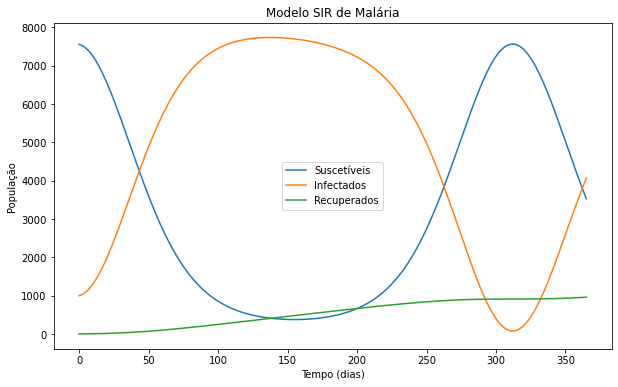

In [31]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [32]:
min(I_H)

78.3857860140879

In [33]:
min(R_H)

0.0

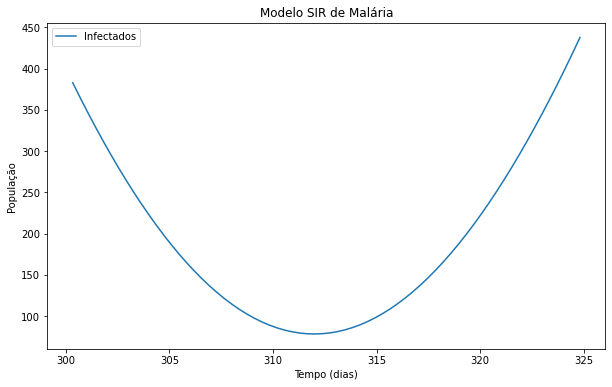

In [34]:
times = sol.t
tempo_inicial = 300
tempo_final = 325

# Encontrando os índices correspondentes ao intervalo desejado
indice_tempo_inicial = np.argmax(times >= tempo_inicial)
indice_tempo_final = np.argmax(times >= tempo_final)

S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
#plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times[indice_tempo_inicial:indice_tempo_final], I_H[indice_tempo_inicial:indice_tempo_final], label='Infectados')
#plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Analisando variações em $\phi_1$:

In [35]:
T1=26.4
T2=0.025
omega1=0.0175
phi1=1.53 # 4.5

R1= 250.083 #146.9
R2= 0.565
omega2= 0.018
phi2=1.5

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=36.5
b1=0.1

A=317.925
B=15
C=-48.78

b2=0.3
tau_H=10
DD=105
Tmin=14.5
gamma= 1/1825 #1/365
R_L = 312
N=8558
M= 300000 #100000
E_M0=50000 # None
I_H0=1000 
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0

In [36]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

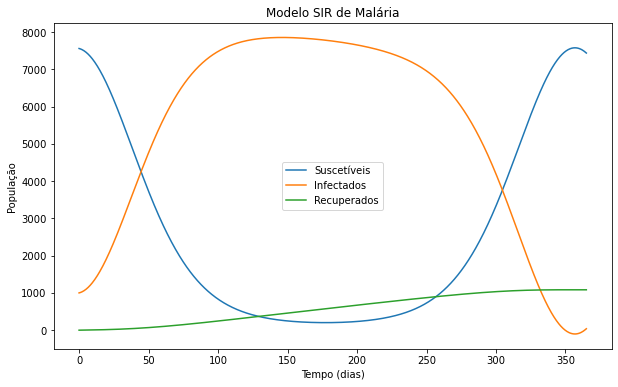

In [37]:
times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

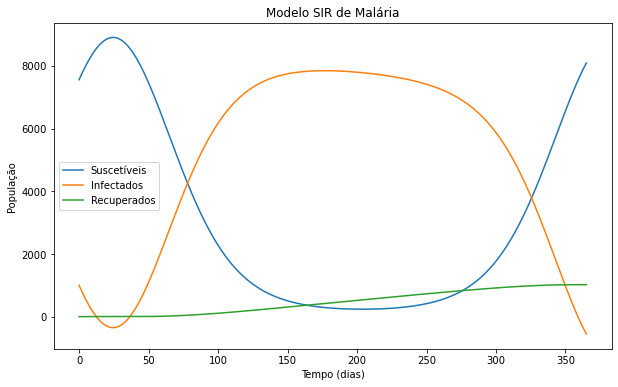

In [38]:
args = (T1, T2, omega1, 2, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

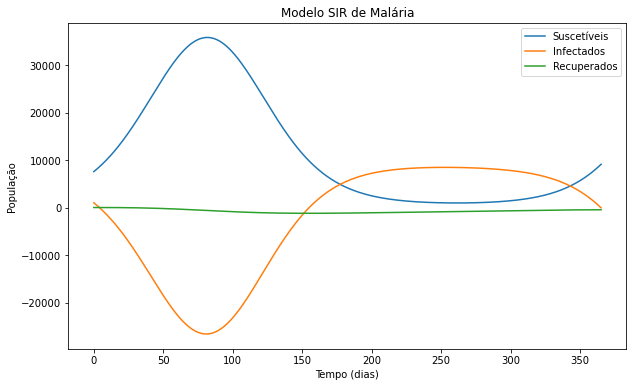

In [39]:
args = (T1, T2, omega1, 3, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

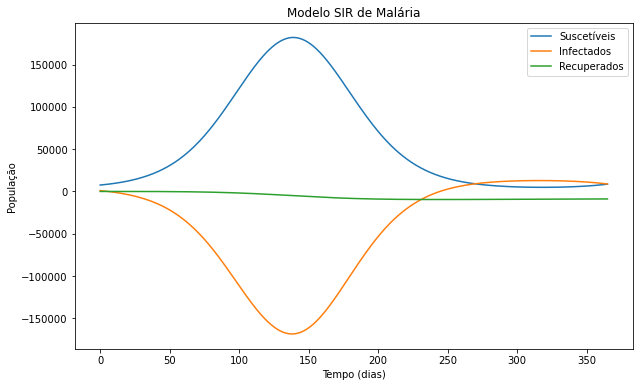

In [40]:
args = (T1, T2, omega1, 4, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

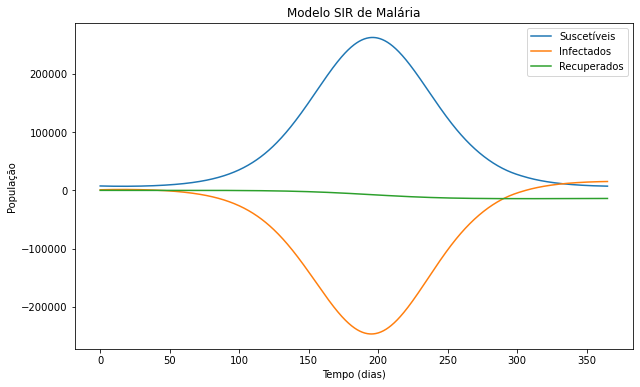

In [41]:
args = (T1, T2, omega1, 5, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

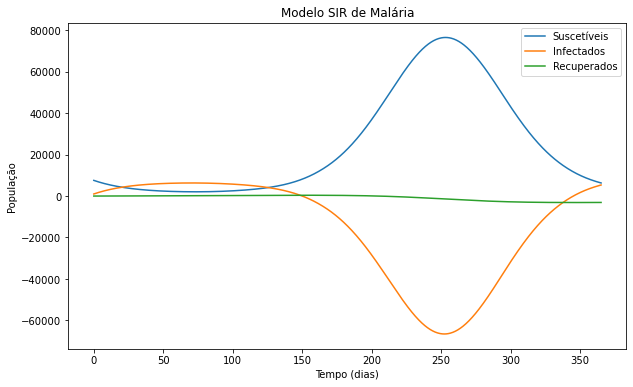

In [42]:
args = (T1, T2, omega1, 6, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

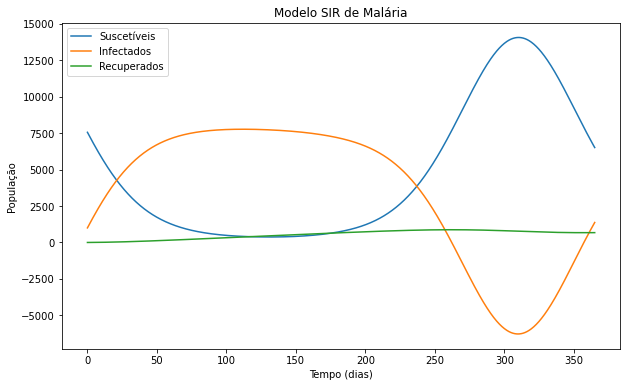

In [43]:
args = (T1, T2, omega1, 7, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

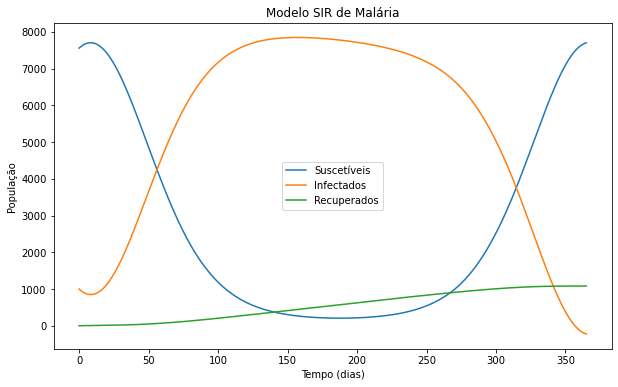

In [44]:
args = (T1, T2, omega1, 8, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

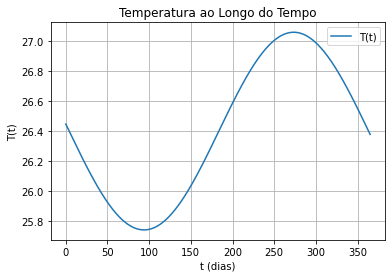

In [45]:
T1= 26.4 
T2= 0.025
omega1= 0.0175
phi1= -1.5

def T(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))
        
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
T_values = [T(t) for t in t_values]

# Plotando
plt.plot(t_values, T_values, label='T(t)')
plt.title('Temperatura ao Longo do Tempo')
plt.xlabel('t (dias)')
plt.ylabel('T(t)')
plt.legend()
plt.grid(True)
plt.show()

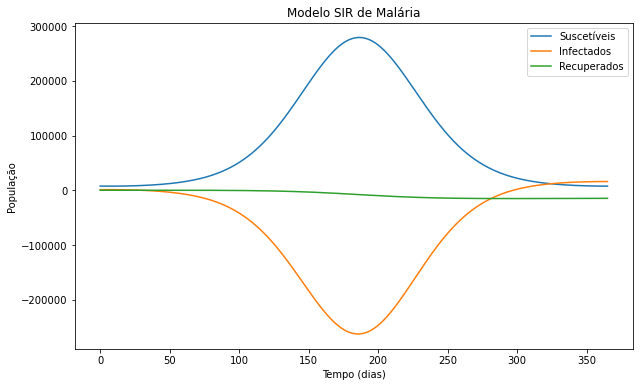

In [46]:
args = (T1, T2, omega1, -1.45, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Modificando $a$ para considerar a temperatura decrescente originalmente:

In [47]:
def model(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T1-T_curr) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

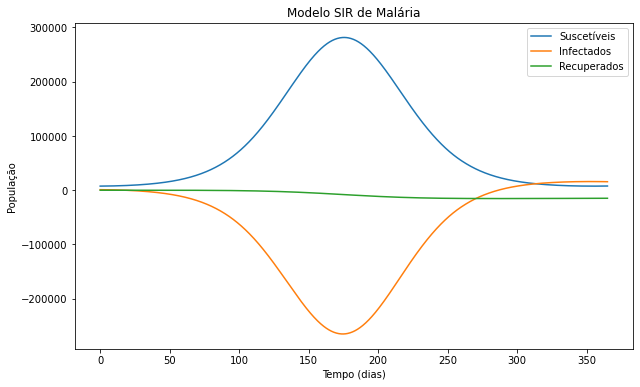

In [48]:
args = (T1, T2, omega1, 1.5, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

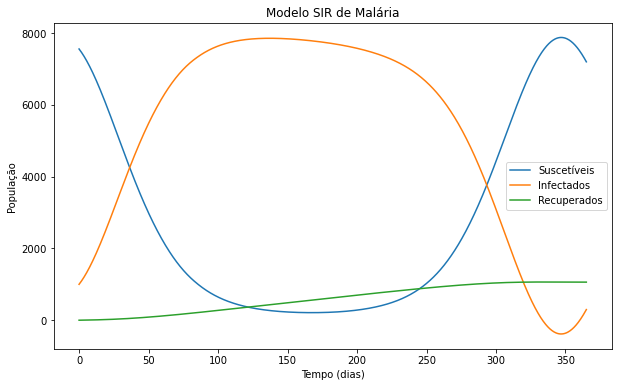

In [49]:
args = (T1, T2, omega1, 4.5, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

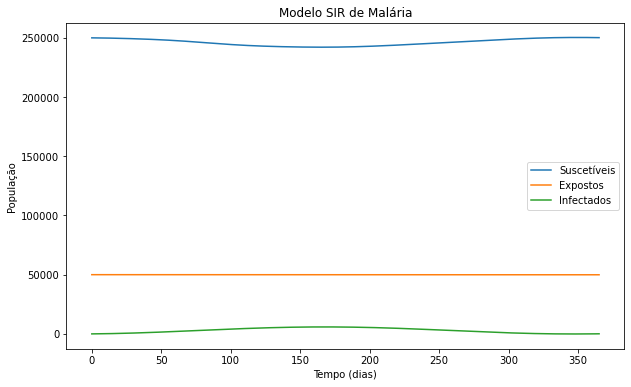

In [50]:
args = (T1, T2, omega1, 4.5, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

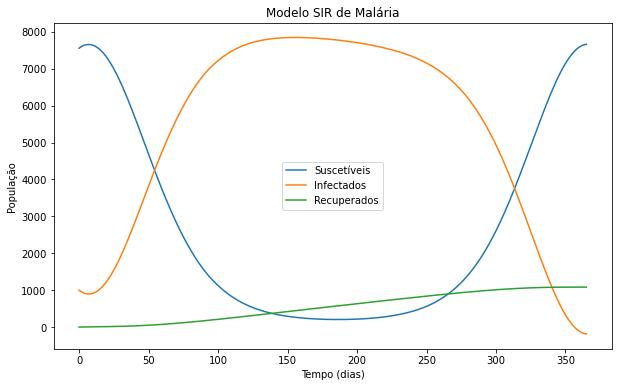

In [51]:
args = (T1, T2, omega1, -1.45, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

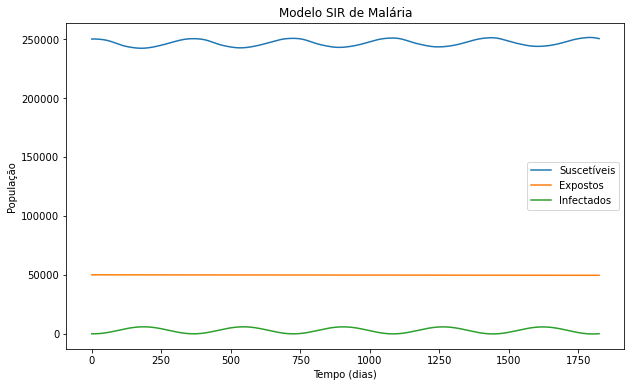

In [52]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [53]:
def model(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T1-T_curr) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    print(b_curr - mu_curr*M)
    print(b_curr)
    print(' ')
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

1.6276353196106528
2.9713210756267583
 
1.6276342245577742
2.9713199842043254
 
1.6276295595627186
2.971315334730257
 
1.6276266795573588
2.9713124642839603
 
1.627622359501794
2.9713081586169503
 
1.627604477288569
2.9712903358231277
 
1.6275988176273664
2.9712846949802896
 
1.6276079430785897
2.9712937901222887
 
1.6276016254571142
2.9712874934841222
 
1.6275640005081085
2.9712499936356074
 
1.6275696161714444
2.971255590613806
 
1.6275414577479592
2.971227525815848
 
1.6275258142553806
2.9712119343152463
 
1.6275258142553806
2.9712119343152463
 
1.6276243689903631
2.9713101614108446
 
1.627613418388903
2.9712992472137607
 
1.6275501486196797
2.9712361877772313
 
1.627468215034667
2.9711545265755555
 
1.6274394156031022
2.9711258229011555
 
1.6273962167167266
2.971082767633874
 
1.6272174028980166
2.9709045483089493
 
1.62716080998725
2.9708481435485217
 
1.6272520590753288
2.9709390892779024
 
1.6271888865083288
2.970876126710528
 
1.6268126715557902
2.9705011626296693
 
1.626868821

 
15.90564697751561
17.19398337950342
 
15.909844038670531
17.20172529862184
 
-1.3456398094640145
-1.7361353685970477e-05
 
-1.0678424398649728
0.2672956596419859
 
-19.342926521224324
-17.955163264040117
 
-37.5563875915201
-36.14613818348338
 
-37.5563875915201
-36.14613818348338
 
11.756108986304946
13.04962683008238
 
11.80198633135868
13.09441092679537
 
11.943364049110981
13.234321886712117
 
13.335628492049675
14.622799139836305
 
13.962034982294583
15.248792930834593
 
12.98224574976935
14.269857423299324
 
13.645630314882988
14.932545220044494
 
15.758915049486221
17.05149268070015
 
16.076588605996307
17.367274203727817
 
10.689015526380077
11.992586153411334
 
4.895264802245854
6.209311107407374
 
4.895264802245854
6.209311107407374
 
11.866912401066267
13.158526448480659
 
12.495249662377518
13.783847277206124
 
13.335871467718118
14.634586837644934
 
2.9081006359079478
4.226499852014398
 
2.0242896393075522
3.344953171715861
 
0.8773851429132578
2.201546078883987
 
-1.294

 
3.4023765913565427
4.696769159669304
 
2.45424825887926
3.749926640136479
 
1.2084529077260073
2.5062334401300337
 
-1.2443059428163092
0.06424571673713543
 
-1.3123796789837092
0.00021259547820118296
 
-1.0880026128806497
0.21821620111486328
 
-1.2983270645093397
0.012225787331841396
 
-9.973729542912332
-8.631387128919068
 
-6.600001574905869
-5.262881244683911
 
-28.550149319962028
-27.186267195990137
 
-37.04461259128035
-35.666082651444235
 
-37.04461259128035
-35.666082651444235
 
3.878954271685129
5.172770299127182
 
3.1198901481028285
4.414644692627856
 
2.070808405655569
3.3670731537362877
 
-0.757092564758107
0.5466718038052214
 
-1.1166029912627775
0.18992873026295798
 
-0.41589015809871066
0.8862696999325657
 
-0.966977940838498
0.33815843190556066
 
-2.521050220730289
-1.194025036221689
 
-1.8217524615514478
-0.498380219607072
 
-10.176422284045263
-8.833799934390319
 
-19.729084357804766
-18.375095964719645
 
-19.729084357804766
-18.375095964719645
 
2.544146836841117
3

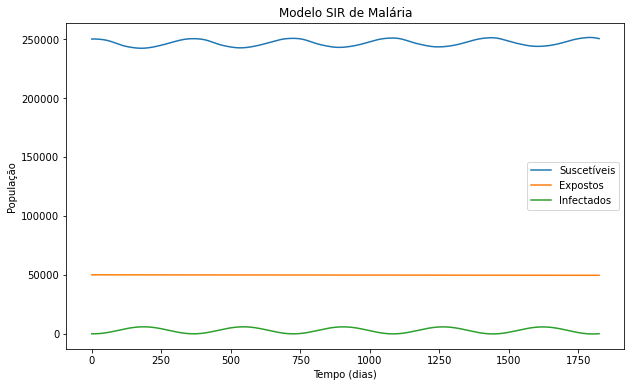

In [54]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [55]:
min(I_M)

-179.66789287693132

De fato, com os parâmetros $A, \ B$ e $C$ passados, $b-\mu M$ fica bem próximo de 0

In [56]:
def model(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, I_M0, I_H0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva 
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T1-T_curr) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    print(p_ER(R_curr))
    print(p_LRT(R_curr,T_curr))
    print(p_PR(R_curr))
    print(' ')
    
    dShdt = -a_curr * b2 * (I_M0 / N) * S_H
    dIhdt = a_curr * b2 * (I_M0 / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H0 / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H0 / N) * S_M - mu_curr * E_M - a_curr * b1 * (I_H0 / N) * S_M * l_curr
    dImdt = a_curr * b1 * (I_H0 / N) * S_M * l_curr - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

0.49940018333179775
0.2569740439337225
0.4716557287022534
 
0.4994001221917697
0.2569740126484382
0.4716556709588936
 
0.49939986173427015
0.2569738793726251
0.4716554249712551
 
0.49939970093546054
0.25697379709205237
0.4716552731057127
 
0.49939945973718824
0.256973673671163
0.4716550453073444
 
0.4993984613232977
0.2569731627838697
0.4716541023608922
 
0.4993981453284696
0.25697300108965954
0.4716538039213323
 
0.49939865482976237
0.2569732618009168
0.47165428511699775
 
0.4993983020981306
0.2569730813085249
0.47165395198156773
 
0.49939620138225527
0.25697200637446227
0.4716519679721299
 
0.4993965149222696
0.25697216681255575
0.4716522640932546
 
0.49939494274188495
0.2569713623295026
0.4716507792562246
 
0.4993940693070746
0.25697091539381106
0.4716499543455705
 
0.4993940693070746
0.25697091539381106
0.4716499543455705
 
0.4993995719313153
0.256973731080774
0.4716551512684644
 
0.4993989605303904
0.2569734182275936
0.4716545738342575
 
0.49939542798305603
0.25697161062690443
0.4

 
0.6449291972374219
0.333891805293668
0.6090997973908985
 
0.6449291972374219
0.333891805293668
0.6090997973908985
 
-0.8129639295407033
-0.4242055068891989
-0.7677992667884419
 
-0.6597370147462003
-0.34416018000498055
-0.6230849583714113
 
0.35383861177248843
0.1837218189439571
0.33418091111846127
 
0.705906400337526
0.36514345749628224
0.6666893780965524
 
0.7330648612137833
0.3790240268452257
0.6923390355907952
 
0.7696402937582624
0.39766787435453727
0.726882499660581
 
0.8699998585658455
0.4482476981825896
0.8216665330899651
 
0.8861124235503754
0.456136903119156
0.8368839555753546
 
0.8566478389504625
0.4416131018281496
0.8090562923421034
 
0.8789703038790362
0.4526631284614133
0.8301386203302008
 
0.8752641651188966
0.4481905360397895
0.8266383781678468
 
0.8851490989298676
0.45360990371913706
0.8359741489893193
 
0.8334430430768445
0.4255828055479286
0.7871406517947974
 
0.8183301481642149
0.41723508405084
0.7728673621550917
 
0.8183301481642149
0.41723508405084
0.77286736215

0.5333731326094793
0.2774450008036623
0.5037412919089526
 
0.5608353653924659
0.29166510955296565
0.5296778450928844
 
0.6000339092921114
0.31194268704829875
0.5666986921092162
 
0.7358447648092205
0.38194816935188375
0.6949645000975969
 
0.7697991240968922
0.3993577628004836
0.7270325060915093
 
0.7129056677690301
0.37015980333296566
0.6732997973374172
 
0.7534957309902768
0.39100503993468677
0.7116348570463725
 
0.8888324536705282
0.4594358971900242
0.8394528729110543
 
0.8792141977416351
0.45474468356567904
0.8303689645337664
 
0.8987809771251114
0.4634002966323167
0.8488487006181608
 
0.8863045028779791
0.45615495907001574
0.8370653638292023
 
0.8863045028779791
0.45615495907001574
0.8370653638292023
 
0.5821016373986082
0.30266930918448065
0.5497626575431299
 
0.6733373156416443
0.3497862707053618
0.6359296869948864
 
0.8997302422929712
0.4643478079869388
0.8497452288322506
 
0.8714163767795983
0.4479008168917825
0.8230043558473982
 
0.8632202453987163
0.4433998670157156
0.8152635

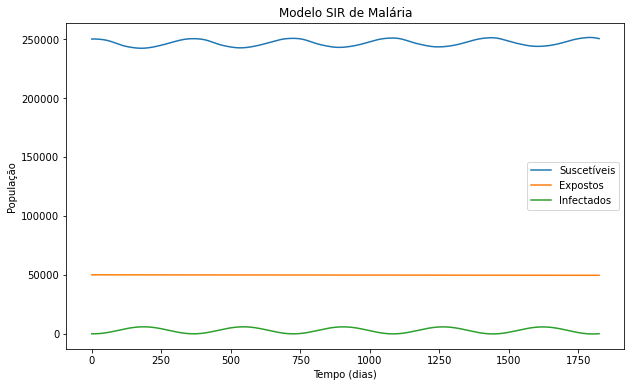

In [57]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

A probabilidade de sobrevivência dos ovos, larvas e pupas dependente de chuva e temperatura está tomando valores negativos em alguns pontos. Isso se dá nos tempos que a precipitação atual fica com valores maiores que $R_L$. Aumentando $R_L$ e verificando o resultado:

In [58]:
R_L

312

0.8187894065132038
0.42132068017683777
0.7733011061513589
 
0.818789385041267
0.42132066941546503
0.7733010858723076
 
0.8187892935704592
0.42132062357183736
0.7733009994832114
 
0.8187892370990584
0.4213205952693223
0.7733009461491106
 
0.8187891523919213
0.4213205528155311
0.7733008661479256
 
0.8187888017557853
0.42132037708259407
0.7733005349915748
 
0.8187886907804943
0.4213203214636409
0.7733004301815778
 
0.8187888697139585
0.42132041114208907
0.773300599174294
 
0.818788745836965
0.4213203490570201
0.7733004821793558
 
0.8187880080787518
0.42131997930495774
0.7732997854077099
 
0.8187881181921245
0.4213200344919398
0.773299889403673
 
0.8187875660514853
0.4213197577682653
0.7732993679375136
 
0.8187872593058994
0.42131960403248214
0.7732990782333492
 
0.8187872593058994
0.42131960403248214
0.7732990782333492
 
0.818789191793712
0.4213205725630455
0.773300903360728
 
0.8187889770739452
0.42132046494911024
0.7733007005698369
 
0.8187877364654569
0.4213198431769075
0.7732995288840

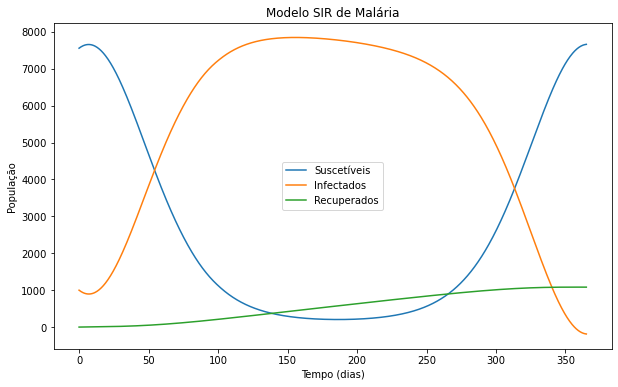

In [59]:
args = (T1, T2, omega1, -1.45, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, 400,
                   N, M, E_M0, I_H0)

t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

0.8187894065132038
0.42132068017683777
0.7733011061513589
 
0.818789385041267
0.42132066941546503
0.7733010858723076
 
0.8187892935704592
0.42132062357183736
0.7733009994832114
 
0.8187892370990584
0.4213205952693223
0.7733009461491106
 
0.8187891523919213
0.4213205528155311
0.7733008661479256
 
0.8187888017557853
0.42132037708259407
0.7733005349915748
 
0.8187886907804943
0.4213203214636409
0.7733004301815778
 
0.8187888697139585
0.42132041114208907
0.773300599174294
 
0.818788745836965
0.4213203490570201
0.7733004821793558
 
0.8187880080787518
0.42131997930495774
0.7732997854077099
 
0.8187881181921245
0.4213200344919398
0.773299889403673
 
0.8187875660514853
0.4213197577682653
0.7732993679375136
 
0.8187872593058994
0.42131960403248214
0.7732990782333492
 
0.8187872593058994
0.42131960403248214
0.7732990782333492
 
0.818789191793712
0.4213205725630455
0.773300903360728
 
0.8187889770739452
0.42132046494911024
0.7733007005698369
 
0.8187877364654569
0.4213198431769075
0.7732995288840

0.7136577108007768
0.36386315150616694
0.6740100602007335
 
0.8919734376963264
0.4610168470014945
0.8424193578243081
 
0.8999936023204351
0.4643592703065197
0.8499939577470774
 
0.7507182433422093
0.38372007802379987
0.7090116742676421
 
0.7165568148481157
0.3650044496341441
0.6767481029121091
 
0.7240099677993408
0.36867355817388775
0.6837871918104884
 
0.7419087139434707
0.37764911052346656
0.7006915631688334
 
0.8576941925576363
0.4367936853260481
0.8100445151933231
 
0.8863740405589512
0.4517624977767765
0.8371310383056759
 
0.8353268444033219
0.4252573489925097
0.7889197974920262
 
0.8736806811679588
0.44509880356692105
0.8251428655475165
 
0.6123959340531983
0.31524049117577274
0.5783739377169094
 
0.7115543294259294
0.3655619433775565
0.672023533346711
 
0.19216667512734573
0.0996850366685
0.18149074873138205
 
0.07595506570062704
0.039557350681425754
0.07173533982836998
 
0.07595506570062704
0.039557350681425754
0.07173533982836998
 
0.7130117055883559
0.36335827261578507
0.673

0.1878519822196054
 
0.12589250689682788
0.0652919798617161
0.11889847873589296
 
0.1090608319828009
0.05659451490327766
0.10300189687264528
 
0.13777140272995975
0.0714273844967353
0.1301174359116286
 
0.11700548526347858
0.06070031472868336
0.11050518052661865
 
0.08214494188582043
0.04275487817196473
0.07758133400327483
 
0.07725782852912648
0.04019440493849559
0.072965726944175
 
0.1362580274278618
0.07101844840141219
0.12868813701520276
 
0.20281985403616518
0.10578181185787897
0.19155208436748933
 
0.20281985403616518
0.10578181185787897
0.19155208436748933
 
0.208787111445842
0.10805461952980189
0.1971878274766285
 
0.1588490242453632
0.08230778233433984
0.15002407845395413
 
0.10909075876328587
0.056831463219008754
0.10303016105421442
 
0.23228157297058802
0.12116985533143665
0.21937704113888865
 
0.24786814102216076
0.12931068071476368
0.23409768874315182
 
0.2722120333524704
0.1420248976533682
0.25708914261066645
 
0.38249035723396546
0.19960118640527452
0.36124089294318956
 

0.21914302420991583
0.1129012759148366
0.20696841175380937
 
0.2017375470418196
0.10397656936732134
0.19052990553949625
 
0.11897279460632826
0.06146759610343692
0.11236319490597667
 
0.12881994713173953
0.06653140164042046
0.12166328340219841
 
0.08933060359298393
0.04621792784726233
0.08436779228226259
 
0.07855040702729488
0.04067897076951635
0.07418649552577848
 
0.07855040702729488
0.04067897076951635
0.07418649552577848
 
0.2682439613385902
0.13805133842051695
0.2533415190420018
 
0.23492280621589384
0.12098808555032889
0.2218715392038997
 
0.09883306744930705
0.05110683317398525
0.09334234147990109
 


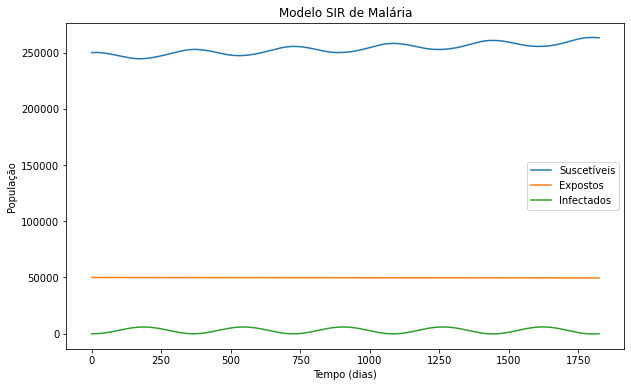

In [60]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 365
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [61]:
min(I_M)

-250.07881589857087

In [62]:
print(f'População inicial = {S_M[0]+E_M[0]+I_M[0]}')
print(f'População final = {S_M[-1]+E_M[-1]+I_M[-1]}')

População inicial = 300000.0
População final = 312783.77774641477
